In [1]:
#My default packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from dataclasses import dataclass
import itertools
import heapq
import networkx as nx

# Day 16

In [2]:
import typing

@dataclass
class Valve:
    name : str
    rate : int
    tunnels : typing.Set[str]

    @classmethod
    def frominput(cls,line):
        _, name, line = line.rstrip().split(" ",2)
        rate, line = line.split("=")[1].split(";")
        rate = int(rate)
        line = line.split("valve")[1]
        if line[0]=="s": line = line[2:]
        else: line = line[1:]
        valves = set(line.split(", "))
        return Valve(name,rate,valves)


In [3]:
pipenet ={}
with open("input16.txt") as f:
    pipes = nx.Graph()
    while l:= f.readline():
        v = Valve.frominput(l)
        pipes.add_node(v.name,rate=v.rate)
        pipes.add_edges_from((v.name,v2) for v2 in v.tunnels)
        pipenet[v.name] = v
expipenet ={}
with open("ex16.txt") as f:
    expipes = nx.Graph()

    while l:= f.readline():
        v = Valve.frominput(l)
        expipenet[v.name] = v
        expipes.add_node(v.name,rate=v.rate)
        expipes.add_edges_from((v.name,v2) for v2 in v.tunnels)

In [4]:
def naiveincreasethepressure(pnet,pos="AA",mins=30,openvalves=None,totP=0,visited=None,path=None):
    if openvalves is None:
        openvalves = []
    if visited is None:
        visited={}
    # if maxvalves is not None:
    #     maxvalves = len([v.rate for v in pnet.values() if v.rate>0])
    # print(pos,mins,totP,len(openvalves))
    if mins == 0:
        print(visited)
        return totP
    elif pos in visited and len(openvalves) == visited[pos] :
        return 0 #Not optimal
    else:
        newP = totP+flowrate(pnet,openvalves)
        resP = newP
        v = pnet[pos]
        visited[pos] = len(openvalves)
        if pos not in openvalves and v.rate>0:            
            resP = max(resP,increasethepressure(pnet,pos,mins-1,openvalves+[v.name],newP,visited.copy()))
        for nv in v.tunnels:
            resP = max(resP,increasethepressure(pnet,nv,mins-1,openvalves,newP,visited.copy()))
        return resP

In [5]:
def betterpipes(pipes,st="AA"):
    relevantnodes = {v:pipes.nodes[v]["rate"] for v in pipes.nodes if pipes.nodes[v]["rate"]>0}
    valvedist = nx.floyd_warshall(pipes)

    rpipes = nx.Graph()
    rpipes.add_nodes_from((v,{"rate":r}) for v,r in relevantnodes.items())
    rpipes.add_node(st,rate=pipes.nodes[st]["rate"])
    rpipes.add_edges_from((v1,v2,{"weight":valvedist[v1][v2]}) for v1,v2 in itertools.product(rpipes.nodes,repeat=2) if v1!=v2)
    return rpipes

In [52]:
def openvalve(valve,pos,pipes,time):
    """Return remaining time as well as the generated pressure when opening valve from pos"""
    time = time -int(pipes[pos][valve]["weight"])-1
    return pipes.nodes[valve]["rate"]*time,time

def openmanyvalves(openorder,st,pipes,time):
    releasedP = 0
    pos = st
    remtime = time
    for v in openorder:
        dP,remtime = openvalve(v,pos,pipes,remtime)
        pos=v
        if remtime<0:
            return releasedP+dP,remtime,pos # This path goes nowhere
        releasedP += dP
    return releasedP,remtime,pos


def maxpressure(opened,pipes,time,pos=None):
    "Assume we open valves immediately for the remaining time"
    totP = 0
    if pos is None or  pos not in opened:
        mindist= 0
    else:
        mindist = min([0]+[d["weight"] for v,d in pipes[pos].items() if v not in opened])

    
    for v in pipes.nodes:
        if v not in opened:
            totP+=pipes.nodes[v]["rate"]
    return max(0,int(time-mindist-1)*totP)

In [156]:
def increasethepressure(pipes,st="AA",time = 30):

    pipes = betterpipes(pipes,st)
    
    def possiblevalves(opened,pipes,st="AA"):
        return [opened+[v] for v in pipes.nodes if v not in opened and v!=st]

    maxtotP = 0
    bestpath=[]
    opened = []

    queue = possiblevalves([],pipes)

    while queue:
        toopen = queue.pop()
        releaasedP,remtime,pos = openmanyvalves(toopen,st,pipes,time)
        if remtime<0:
            continue
        elif releaasedP+maxpressure(toopen,pipes,remtime,pos)>maxtotP:
            queue+=possiblevalves(toopen,pipes)
            if releaasedP>maxtotP:
                maxtotP = releaasedP
                bestpath = toopen
    return maxtotP,bestpath

        
        






In [154]:
increasethepressure(expipes,)

(1651, ['DD', 'BB', 'JJ', 'HH', 'EE', 'CC'])

In [155]:
increasethepressure(pipes)


(1986, ['OJ', 'XF', 'OK', 'WY', 'YV', 'JM', 'MQ', 'CU'])

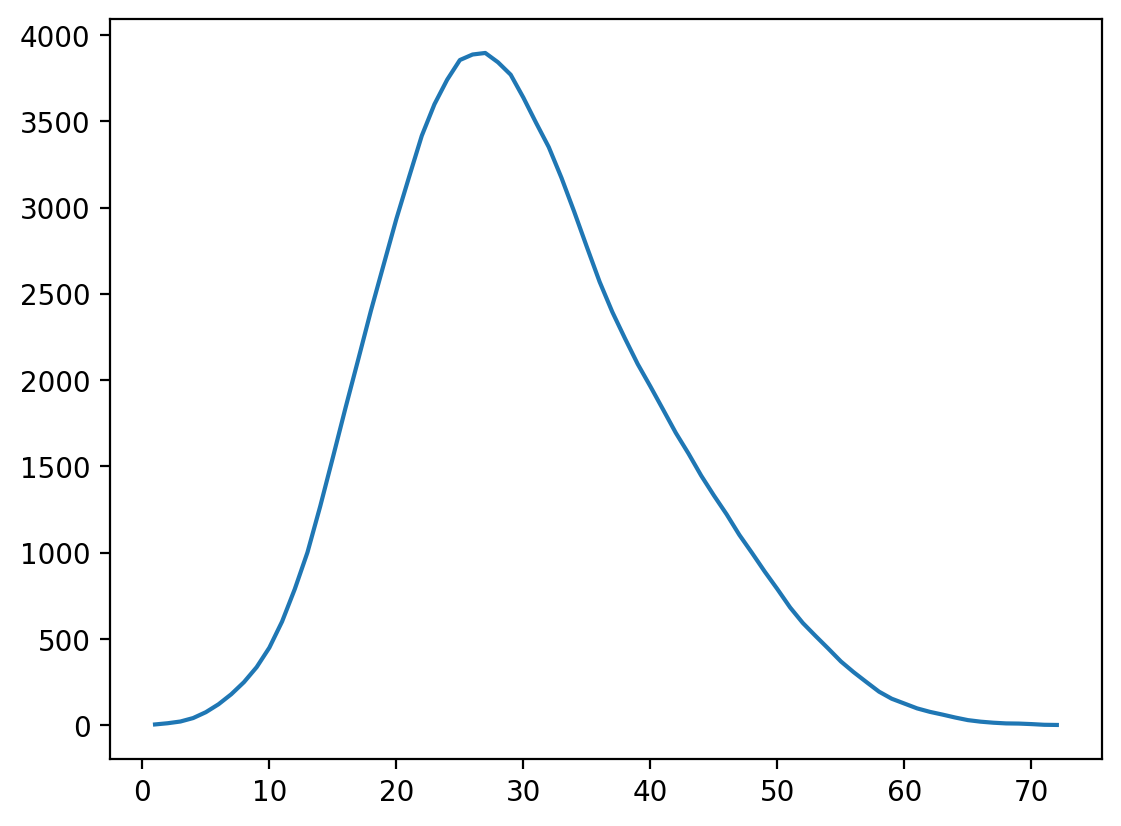

In [145]:
plt.plot(*zip(*sorted(logqueue.items())))

In [157]:
def badincreasethepressurewithanelephant(pipes,logqueue,st="AA",time = 26,):

    pipes = betterpipes(pipes,st)

    
    def possiblevalves2(player1,player2,rt1,rt2,pipes,st="AA",rP=0):
        res = []
        if len(player1)==0: st1=st
        else: st1=player1[-1]
        if len(player2)==0: st2=st
        else: st2=player2[-1]
        for v in pipes.nodes:
            if v not in player1 and v not in player2 and v!=st:
                if pipes[st1][v]["weight"]+1<rt1:
                    res.append((-rP,player1+[v],player2))
                if pipes[st2][v]["weight"]+1<rt2:
                    res.append((-rP,player1,player2+[v]))
        return res

    bestP = 0
    bestpaths=[]
    opened = []

    queue = possiblevalves2([],[],time,time,pipes,rP=0)
    #heapq.heapify(queue)
        # queue = heapq.heapify(possiblevalves2([],[],pipes,rP=0))
    # print(queue)
    k = 0
    while queue:
        k+=1
        logqueue[len(queue)]+=1

        #_,toopeny,toopenel =heapq.heappop(queue)
        _,toopeny,toopenel =queue.pop()

        releaasedPy,remtimey,posy = openmanyvalves(toopeny,st,pipes,time)
        releaasedPel,remtimeel,posel = openmanyvalves(toopenel,st,pipes,time)

        if remtimey<0 or remtimeel<0:
            continue

        maxPy = maxpressure(toopeny+toopenel,pipes,remtimey,posy)
        maxPel = maxpressure(toopeny+toopenel,pipes,remtimeel,posel)
        maxP = max(maxPel,maxPy)
        releaasedP = releaasedPy+releaasedPel

        if k%100000==0:
            print(releaasedP,"\t",remtimey,remtimeel,bestpaths,[n for n in pipes.nodes if n not in bestpaths[0] and n not in bestpaths[1]],len(queue))
        if releaasedP+maxP>bestP:
            for newroute in possiblevalves2(toopeny,toopenel,remtimey,remtimeel,pipes,rP=releaasedP,):
                # heapq.heappush(queue,newroute)
                queue.append(newroute)
            
            if releaasedP>bestP:
                # print(releaasedP)
                bestP = releaasedP
                bestpaths = [toopeny,toopenel]
                print(releaasedP,maxP,remtimey,remtimeel,bestpaths,[n for n in pipes.nodes if n not in bestpaths[0] and n not in bestpaths[1]],len(queue))
    return bestP,bestpaths

483 1500 26 23 [[], ['JJ']] ['DD', 'BB', 'CC', 'EE', 'HH', 'AA'] 21
813 950 26 15 [[], ['JJ', 'HH']] ['DD', 'BB', 'CC', 'EE', 'AA'] 28
846 875 26 11 [[], ['JJ', 'HH', 'EE']] ['DD', 'BB', 'CC', 'AA'] 33
862 825 26 8 [[], ['JJ', 'HH', 'EE', 'CC']] ['DD', 'BB', 'AA'] 36
940 500 26 6 [[], ['JJ', 'HH', 'EE', 'CC', 'BB']] ['DD', 'AA'] 37
1000 0 26 3 [[], ['JJ', 'HH', 'EE', 'CC', 'BB', 'DD']] ['AA'] 36
1420 0 24 6 [['DD'], ['JJ', 'HH', 'EE', 'CC', 'BB']] ['AA'] 35
1594 0 21 8 [['BB', 'DD'], ['JJ', 'HH', 'EE', 'CC']] ['AA'] 34
1615 0 21 8 [['DD', 'BB'], ['JJ', 'HH', 'EE', 'CC']] ['AA'] 32
1616 0 19 11 [['BB', 'DD', 'CC'], ['JJ', 'HH', 'EE']] ['AA'] 29
1630 0 20 11 [['DD', 'CC', 'BB'], ['JJ', 'HH', 'EE']] ['AA'] 29
1637 0 19 11 [['DD', 'BB', 'CC'], ['JJ', 'HH', 'EE']] ['AA'] 27
1645 0 16 15 [['DD', 'CC', 'BB', 'EE'], ['JJ', 'HH']] ['AA'] 22
1652 0 16 15 [['DD', 'BB', 'CC', 'EE'], ['JJ', 'HH']] ['AA'] 20
1661 0 19 12 [['DD', 'HH'], ['JJ', 'CC', 'BB', 'EE']] ['AA'] 22
1670 0 15 16 [['DD', 'HH', '

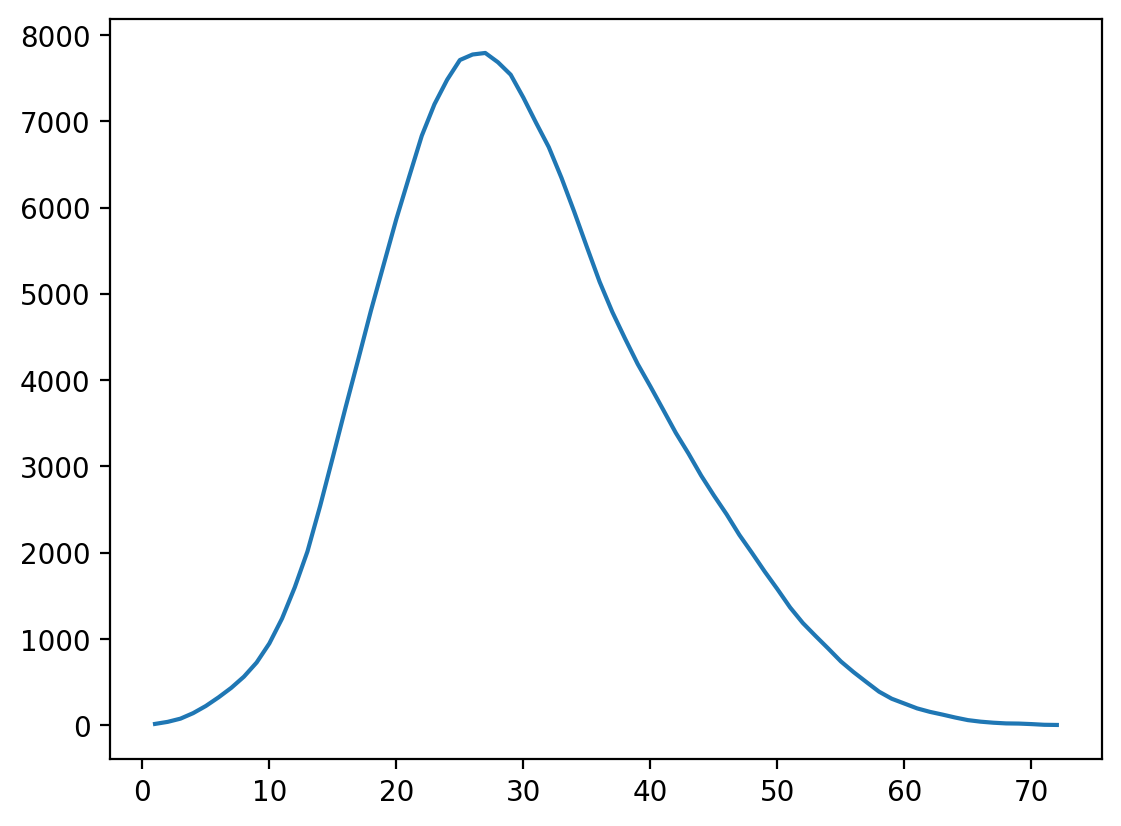

In [158]:
logqueueex = defaultdict(int)
badincreasethepressurewithanelephant(expipes,logqueueex,time=26)
plt.plot(*zip(*sorted(logqueue.items())))

In [165]:
betterpipes(expipes)["AA"]["BB"]

{'weight': 1.0}

In [188]:


def increasethepressurewithanelephant(pipes,st="AA",time = 26,):

    pipes = betterpipes(pipes,st)
    
    def allvalveorders(pipes, node, todo, done, time):
        for next_node in todo:
            cost = int(pipes[node][next_node]["weight"]) + 1
            if cost < time:
                yield from allvalveorders(pipes, next_node, todo - {next_node},
                                    done + [next_node],time - cost)
        yield done

    valves = allvalveorders(pipes, st, set(n for n in pipes.nodes if n !=st), [], 26)

    allPressures=[]

    paths = set()
    for vo in valves:
        releasedP,_,_ =  openmanyvalves(vo,st,pipes, time)
        allPressures.append((releasedP,vo))


    allPressures.sort(key=lambda x:-x[0])
    bestP = 0

    for j,(pa,voa) in enumerate(allPressures):
        if 2*pa<bestP:
            break
        for pb,vob in allPressures[j+1:]:
            if not set(voa)&set(vob):
                if pa+pb>bestP:
                    bestP = pa+pb
                    bestpaths=(voa,vob)
            

    return bestP,bestpaths

In [189]:
bP,bpaths = increasethepressurewithanelephant(pipes)

In [190]:
bP

2464